In [3]:
import cv2
import numpy as np
import pandas as pd
import config

from matplotlib import pyplot as plt
from detector import clock_face as cf
from detector import time_reader as tr 

In [4]:
images = [
    cv2.imread('../test images/timer/1.jpg', cv2.IMREAD_COLOR),
    cv2.imread('../test images/timer/2.jpg', cv2.IMREAD_COLOR),
    cv2.imread('../test images/timer/3.jpg', cv2.IMREAD_COLOR),
]

In [5]:
def read_transparent_png(filename):
    image_4channel = cv2.imread(filename, cv2.IMREAD_UNCHANGED)
    alpha_channel = image_4channel[:,:,3]
    rgb_channels = image_4channel[:,:,:3]

    # White Background Image
    white_background_image = np.ones_like(rgb_channels, dtype=np.uint8) * 255

    # Alpha factor
    alpha_factor = alpha_channel[:,:,np.newaxis].astype(np.float32) / 255.0
    alpha_factor = np.concatenate((alpha_factor,alpha_factor,alpha_factor), axis=2)

    # Transparent Image Rendered on White Background
    base = rgb_channels.astype(np.float32) * alpha_factor
    white = white_background_image.astype(np.float32) * (1 - alpha_factor)
    final_image = base + white
    return final_image.astype(np.uint8)

In [6]:
def find_template(im, template):
    template = cv2.cvtColor(template, cv2.COLOR_BGR2GRAY)
    g_im = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
    h, w = template.shape
  
    res = cv2.matchTemplate(g_im, template, cv2.TM_CCOEFF_NORMED)
    min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(res)
    
    top_left = max_loc
    bottom_right = (top_left[0] + w, top_left[1] + h)
    
    part = im[top_left[1]:bottom_right[1], top_left[0]:bottom_right[0]]
    return part

In [7]:
templates = [
    read_transparent_png('../resources/timer/face.png'),
    read_transparent_png('../resources/timer/hand.png'),
    read_transparent_png('../resources/timer/small_face.png'),
    read_transparent_png('../resources/timer/small_hand.png'),
]

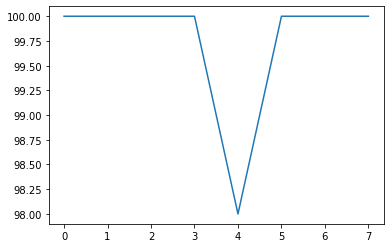

In [18]:
f = cv2.resize(templates[1], (8, 100))
f = cv2.cvtColor(f, cv2.COLOR_BGR2GRAY)
g = tr.TimeReader.convert_image_to_graph(f)

plt.plot(g)

In [8]:
rotated = [tr.TimeReader.get_rotated(im, templates[0]) for im in images]

s_rotated = [find_template(im, templates[2]) for im, _ in rotated]
s_rotated = [cf.ClockFace.wrap_polar_face(im, error_height=30) for im in s_rotated]

# s_rotated = [tr.TimeReader.sift_get_rotated(im, templates[2]) for im in images]
# s_rotated = [im for (_, im) in s_rotated]

rotated = [im for _, im in rotated]
n_rotated = []

for i in range(len(rotated)):
    add = np.copy(rotated[i][0:rotated[i].shape[0], 0:15])
    n_im = np.concatenate((rotated[i], add), axis=1)
    n_rotated.append((n_im, s_rotated[i]))

rotated = n_rotated

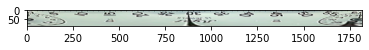

In [9]:
plt.imshow(rotated[0][0])

In [19]:
def get_head_of_hand(im):
    im = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
    g = tr.TimeReader.convert_image_to_graph(im)
    return g.index(min(g))

In [10]:
# im1 - template, im2 - search field
def get_correlation_graph(im1, im2):
#     im1 = cv2.cvtColor(im1, cv2.COLOR_BGR2GRAY)
    
    result = []
    x = 0
    dx = im1.shape[1] # h, w, c
    
    if im1.shape[0] != im2.shape[0]:
        im1 = cv2.resize(im1, (im1.shape[1], im2.shape[0]), interpolation = cv2.INTER_AREA)
    
    while not dx > im2.shape[1]:
        part = np.copy(im2[85 - im2.shape[1]:im2.shape[0], x:dx])
#         part = cv2.cvtColor(part, cv2.COLOR_BGR2GRAY)
#         result.append(np.correlate(im1, part, mode='same'))
        corr = cv2.matchTemplate(im1, part, cv2.TM_CCOEFF_NORMED)[0][0]
        result.append(corr)
        x += 1
        dx += 1
    
    return result

In [23]:
print(templates[1].shape)

(164, 8, 3)


In [28]:
def get_time(pair):
    im, s_im = pair
    
    temp_hand = templates[1]
    temp_s_face = templates[2]
    temp_s_hand = templates[3]
    
    if temp_hand.shape[0] > im.shape[0]:
        temp_hand = cv2.resize(temp_hand, (temp_hand.shape[1], im.shape[0]))
    if temp_s_hand.shape[0] > im.shape[0]:
        temp_s_hand = cv2.resize(temp_s_hand, (temp_s_hand.shape[1], im.shape[0]))
    
    g_hand = get_correlation_graph(temp_hand, im)
    plt.plot(g_hand), plt.show()
    
    g_s_hand = get_correlation_graph(temp_s_hand, s_im)
    plt.plot(g_s_hand), plt.show()
    
    pos_hand = g_hand.index(max(g_hand))
    
    if config.DEFAULT_WRAP_POLAR_WIDTH - config.DEFAULT_WRAP_POLAR_WIDTH*0.83 <= pos_hand <= config.DEFAULT_WRAP_POLAR_WIDTH:
        max_pos_hand = 0
        for i in range(int(config.DEFAULT_WRAP_POLAR_WIDTH // 2.4), int(config.DEFAULT_WRAP_POLAR_WIDTH // 1.8), 1):
                if g_hand[i] >= 0.32 and g_hand[i] >= max_pos_hand:
                    pos_hand = i
                    max_pos_hand = i
                
    pos_s_hand = g_s_hand.index(max(g_s_hand))
    pos_hand += get_head_of_hand(temp_hand)
    pos_s_hand += get_head_of_hand(temp_s_hand)

    pos_hand %= config.DEFAULT_WRAP_POLAR_WIDTH
    pos_s_hand %= config.DEFAULT_WRAP_POLAR_WIDTH
    
    if (pos_s_hand * 30 // config.DEFAULT_WRAP_POLAR_WIDTH) in [14, 15] and \
        (pos_hand * 60 // config.DEFAULT_WRAP_POLAR_WIDTH) == 60:
        pos_s_hand = 0
    
    return (pos_s_hand * 30 // config.DEFAULT_WRAP_POLAR_WIDTH, pos_hand * 60 / config.DEFAULT_WRAP_POLAR_WIDTH)

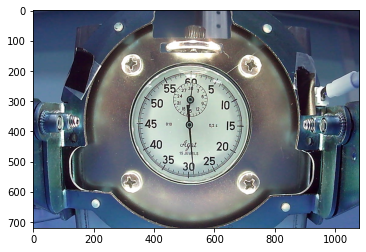

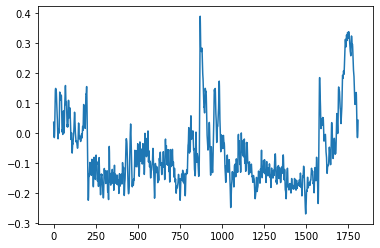

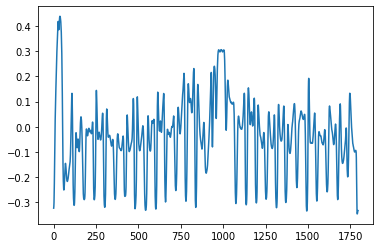

(0, 29.1)


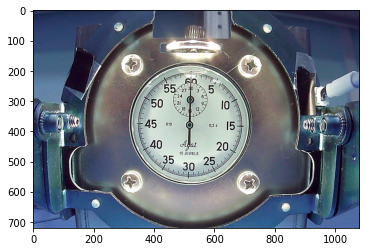

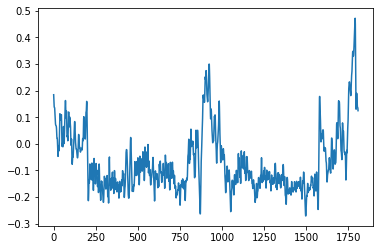

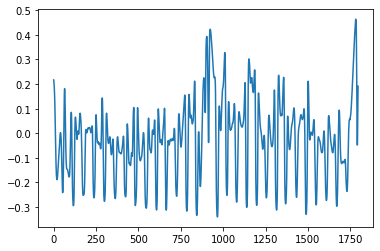

(29, 59.8)


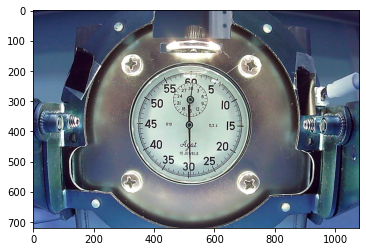

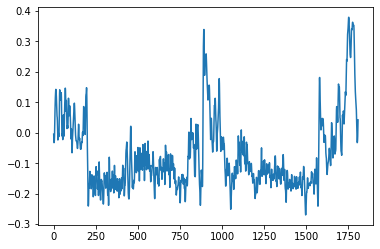

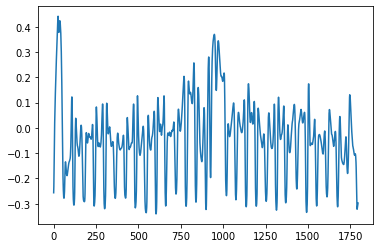

(0, 29.833333333333332)


In [29]:
for idx, pair in enumerate(rotated):
    plt.imshow(images[idx]), plt.show()
    time = get_time(pair)
    print(time)